In [3]:
import pandas as pd
import numpy as np
from faker import Faker
import random

# Initialize
fake = Faker()
np.random.seed(42)
random.seed(42)

# Parameters
n_invoices = 10000
customer_ids = [f"CUST{str(i).zfill(5)}" for i in range(1, 1001)]  # 1000 customers

def generate_invoice(invoice_num):
    customer_id = random.choice(customer_ids)
    
    invoice_date = fake.date_between(start_date='-1y', end_date='today')
    invoice_date = pd.to_datetime(invoice_date)
    
    due_days = random.choice([15, 30, 45, 60])
    due_date = invoice_date + pd.Timedelta(days=due_days)
    
    delay_options = [0, 0, 0, 5, 10, 15, 30, -5, -10]
    delay_probs = [0.5, 0.2, 0.1, 0.05, 0.05, 0.05, 0.03, 0.01, 0.01]
    delay = np.random.choice(delay_options, p=delay_probs)
    payment_date = due_date + pd.Timedelta(days=delay)
    
    invoice_amount = round(np.random.exponential(scale=1000), 2)
    
    return {
        "Invoice_ID": f"INV{str(invoice_num).zfill(6)}",
        "Customer_ID": customer_id,
        "Invoice_Date": invoice_date,
        "Due_Date": due_date,
        "Payment_Date": payment_date,
        "Invoice_Amount": invoice_amount
    }

# Generate data
data = [generate_invoice(i) for i in range(n_invoices)]
df = pd.DataFrame(data)

for col in ["Invoice_Amount", "Payment_Date"]:
    missing_indices = df.sample(frac=0.01, random_state=42).index
    df.loc[missing_indices, col] = np.nan

# Save to CSV
df.to_csv("synthetic_ar_data.csv", index=False)

print("✅ Synthetic dataset generated: synthetic_ar_data.csv")

✅ Synthetic dataset generated: synthetic_ar_data.csv


In [5]:
import pandas as pd


df = pd.read_csv("synthetic_ar_data.csv", parse_dates=["Invoice_Date", "Due_Date", "Payment_Date"])


df_clean = df.dropna(subset=["Payment_Date", "Invoice_Amount"]).copy()

df_clean.loc[:, "Days_To_Pay"] = (df_clean["Payment_Date"] - df_clean["Invoice_Date"]).dt.days
df_clean.loc[:, "Days_Overdue"] = (df_clean["Payment_Date"] - df_clean["Due_Date"]).dt.days
df_clean.loc[:, "Paid_Late"] = df_clean["Days_Overdue"].apply(lambda x: 1 if x > 0 else 0)
df_clean.loc[:, "Invoice_Month"] = df_clean["Invoice_Date"].dt.month
df_clean.loc[:, "Invoice_Year"] = df_clean["Invoice_Date"].dt.year

print(df_clean.head())
print("\nLate Payment Ratio:")
print(df_clean["Paid_Late"].value_counts(normalize=True))

  Invoice_ID Customer_ID Invoice_Date   Due_Date Payment_Date  Invoice_Amount  \
0  INV000000   CUST00655   2024-08-15 2024-08-30   2024-08-30         3010.12   
1  INV000001   CUST00026   2025-01-20 2025-03-06   2025-03-06          912.94   
2  INV000002   CUST00251   2024-10-08 2024-11-07   2024-11-07          169.60   
3  INV000003   CUST00143   2024-07-19 2024-08-03   2024-08-03         2011.23   
4  INV000004   CUST00693   2025-05-18 2025-06-02   2025-06-02         1231.25   

   Days_To_Pay  Days_Overdue  Paid_Late  Invoice_Month  Invoice_Year  
0           15             0          0              8          2024  
1           45             0          0              1          2025  
2           30             0          0             10          2024  
3           15             0          0              7          2024  
4           15             0          0              5          2025  

Late Payment Ratio:
Paid_Late
0    0.821818
1    0.178182
Name: proportion, dtype: flo

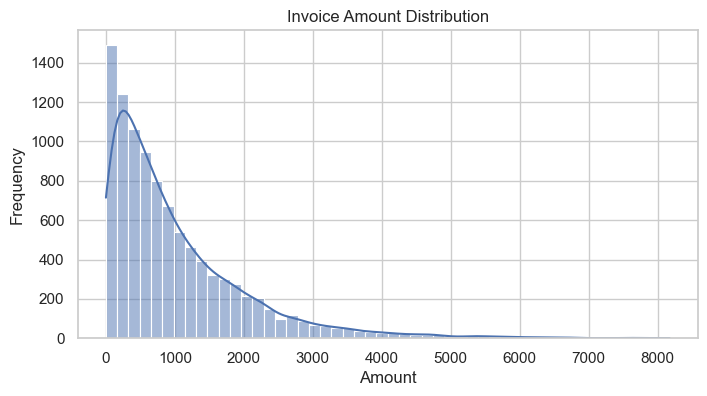

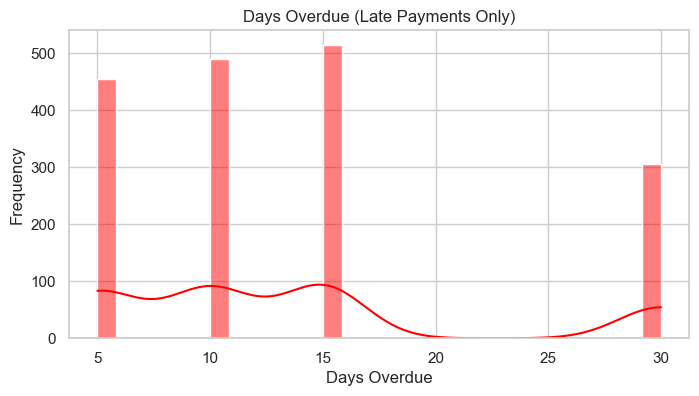

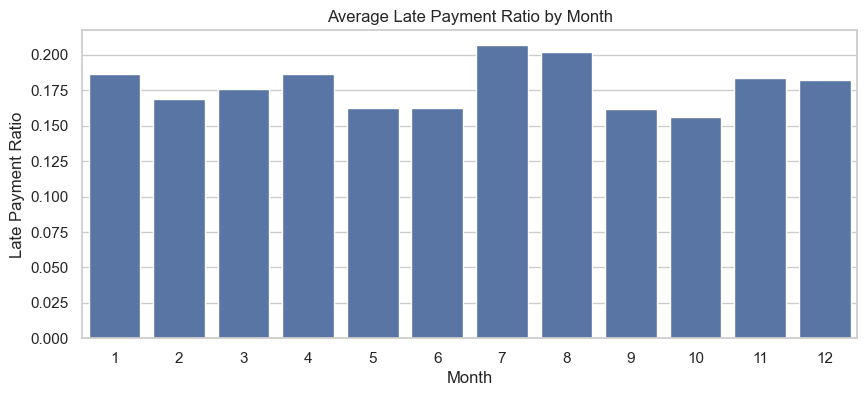

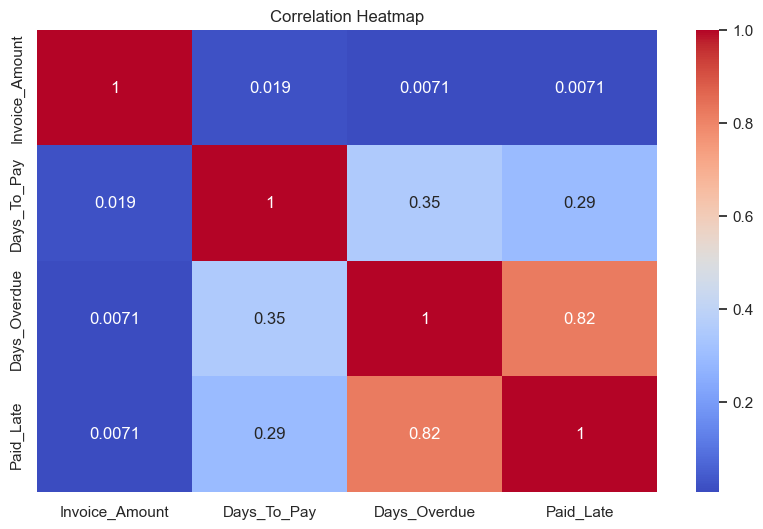

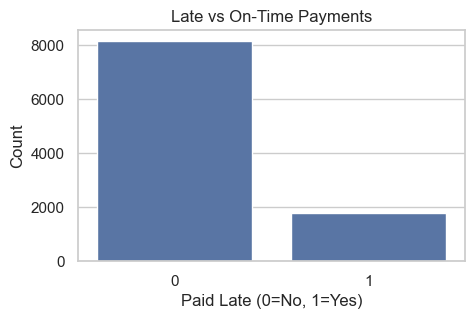

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

# Distribution of Invoice Amounts
plt.figure(figsize=(8, 4))
sns.histplot(df_clean["Invoice_Amount"], bins=50, kde=True)
plt.title("Invoice Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

# Days Overdue Distribution (only late payers)
plt.figure(figsize=(8, 4))
sns.histplot(df_clean[df_clean["Paid_Late"] == 1]["Days_Overdue"], bins=30, kde=True, color='red')
plt.title("Days Overdue (Late Payments Only)")
plt.xlabel("Days Overdue")
plt.ylabel("Frequency")
plt.show()

# Late Payment Ratio by Month
monthly = df_clean.groupby("Invoice_Month")["Paid_Late"].mean()
plt.figure(figsize=(10, 4))
sns.barplot(x=monthly.index, y=monthly.values)
plt.title("Average Late Payment Ratio by Month")
plt.xlabel("Month")
plt.ylabel("Late Payment Ratio")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean[["Invoice_Amount", "Days_To_Pay", "Days_Overdue", "Paid_Late"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Paid_Late Count Plot
plt.figure(figsize=(5, 3))
sns.countplot(x="Paid_Late", data=df_clean)
plt.title("Late vs On-Time Payments")
plt.xlabel("Paid Late (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Select features and target
features = ["Invoice_Amount", "Days_To_Pay", "Invoice_Month", "Invoice_Year"]
X = df_clean[features]
y = df_clean["Paid_Late"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\n🚀 ROC-AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1627
           1       1.00      0.04      0.08       353

    accuracy                           0.83      1980
   macro avg       0.91      0.52      0.49      1980
weighted avg       0.86      0.83      0.76      1980


📉 Confusion Matrix:
[[1627    0]
 [ 339   14]]

🚀 ROC-AUC Score: 0.707


In [9]:
from sklearn.ensemble import RandomForestClassifier

#Random Forest with class_weight to handle imbalance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Model Traning
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("🔍 Classification Report (Random Forest):")
print(classification_report(y_test, rf_pred))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

print(f"\n🚀 ROC-AUC Score: {roc_auc_score(y_test, rf_proba):.3f}")


🔍 Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1627
           1       0.71      0.67      0.69       353

    accuracy                           0.89      1980
   macro avg       0.82      0.80      0.81      1980
weighted avg       0.89      0.89      0.89      1980


📉 Confusion Matrix:
[[1530   97]
 [ 117  236]]

🚀 ROC-AUC Score: 0.849


In [10]:
# Customer-level aggregation
customer_df = df_clean.groupby("Customer_ID").agg({
    "Invoice_Amount": "sum",
    "Paid_Late": "mean",
    "Days_Overdue": "mean",
    "Invoice_ID": "count"
}).reset_index()

customer_df.columns = ["Customer_ID", "Total_AR", "Late_Payment_Ratio", "Avg_Days_Overdue", "Num_Invoices"]
customer_df.fillna(0, inplace=True)

customer_df.head()

,Customer_ID,Total_AR,Late_Payment_Ratio,Avg_Days_Overdue,Num_Invoices
0,CUST00001,14256.75,0.153846,0.769231,13
1,CUST00002,7077.10,0.200000,1.500000,10
2,CUST00003,6901.79,0.000000,0.000000,10
3,CUST00004,18902.98,0.166667,3.333333,12
4,CUST00005,9838.45,0.200000,4.000000,10


In [11]:
from sklearn.preprocessing import StandardScaler

features_to_scale = customer_df[["Total_AR", "Late_Payment_Ratio", "Avg_Days_Overdue", "Num_Invoices"]]

# Standardize
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
customer_df["Cluster"] = kmeans.fit_predict(scaled_features)

C:\Users\Sivarajan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [13]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

In [14]:
df_clean["Predicted_Late"] = rf_model.predict(X)  # Use full feature set if needed

df_final = df_clean.merge(customer_df[["Customer_ID", "Cluster"]], on="Customer_ID", how="left")

df_final.head()

,Invoice_ID,Customer_ID,Invoice_Date,Due_Date,Payment_Date,Invoice_Amount,Days_To_Pay,Days_Overdue,Paid_Late,Invoice_Month,Invoice_Year,Predicted_Late,Cluster
0,INV000000,CUST00655,2024-08-15,2024-08-30,2024-08-30,3010.12,15,0,0,8,2024,0,2
1,INV000001,CUST00026,2025-01-20,2025-03-06,2025-03-06,912.94,45,0,0,1,2025,0,0
2,INV000002,CUST00251,2024-10-08,2024-11-07,2024-11-07,169.60,30,0,0,10,2024,0,1
3,INV000003,CUST00143,2024-07-19,2024-08-03,2024-08-03,2011.23,15,0,0,7,2024,0,0
4,INV000004,CUST00693,2025-05-18,2025-06-02,2025-06-02,1231.25,15,0,0,5,2025,0,0


In [15]:
def assign_strategy(row):
    if row["Predicted_Late"] == 1 and row["Cluster"] == 2:
        return "Escalated Follow-up"
    elif row["Predicted_Late"] == 1 and row["Cluster"] == 1:
        return "Personalized Outreach"
    elif row["Predicted_Late"] == 0 and row["Cluster"] == 0:
        return "Gentle Reminder"
    else:
        return "Standard Reminder"

df_final["Collection_Strategy"] = df_final.apply(assign_strategy, axis=1)

<Axes: title={'center': 'Strategy Distribution'}, xlabel='Collection_Strategy'>

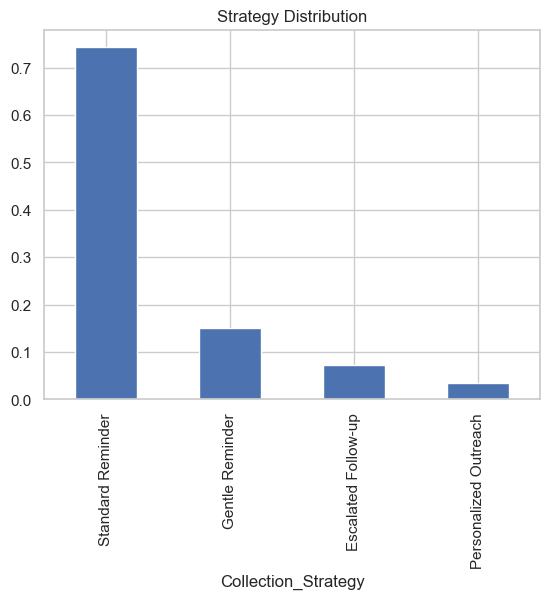

In [16]:
df_final["Collection_Strategy"].value_counts(normalize=True).plot(kind="bar", title="Strategy Distribution")

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.52      0.64      1627
           1       0.18      0.50      0.27       353

    accuracy                           0.51      1980
   macro avg       0.50      0.51      0.45      1980
weighted avg       0.71      0.51      0.57      1980



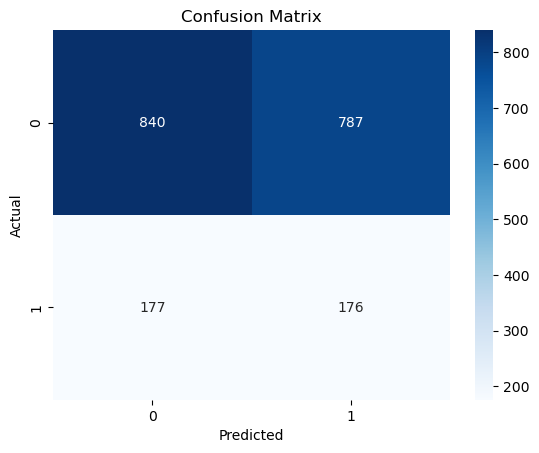

🚀 ROC-AUC Score: 0.5059


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

df_clean = df.dropna(subset=["Payment_Date", "Invoice_Amount"]).copy()
df_clean["Days_To_Pay"] = (df_clean["Payment_Date"] - df_clean["Invoice_Date"]).dt.days
df_clean["Days_Overdue"] = (df_clean["Payment_Date"] - df_clean["Due_Date"]).dt.days
df_clean["Paid_Late"] = df_clean["Days_Overdue"].apply(lambda x: 1 if x > 0 else 0)
df_clean["Invoice_Month"] = df_clean["Invoice_Date"].dt.month
df_clean["Invoice_Year"] = df_clean["Invoice_Date"].dt.year

# Customer_ID
le = LabelEncoder()
df_clean["Customer_ID_Encoded"] = le.fit_transform(df_clean["Customer_ID"])

# Features and Target
features = ["Invoice_Amount", "Invoice_Month", "Invoice_Year", "Customer_ID_Encoded"]
X = df_clean[features]
y = df_clean["Paid_Late"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression with Balanced Class Weights
model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_test, y_proba)
print(f"🚀 ROC-AUC Score: {roc_auc:.4f}")

C:\Users\Sivarajan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


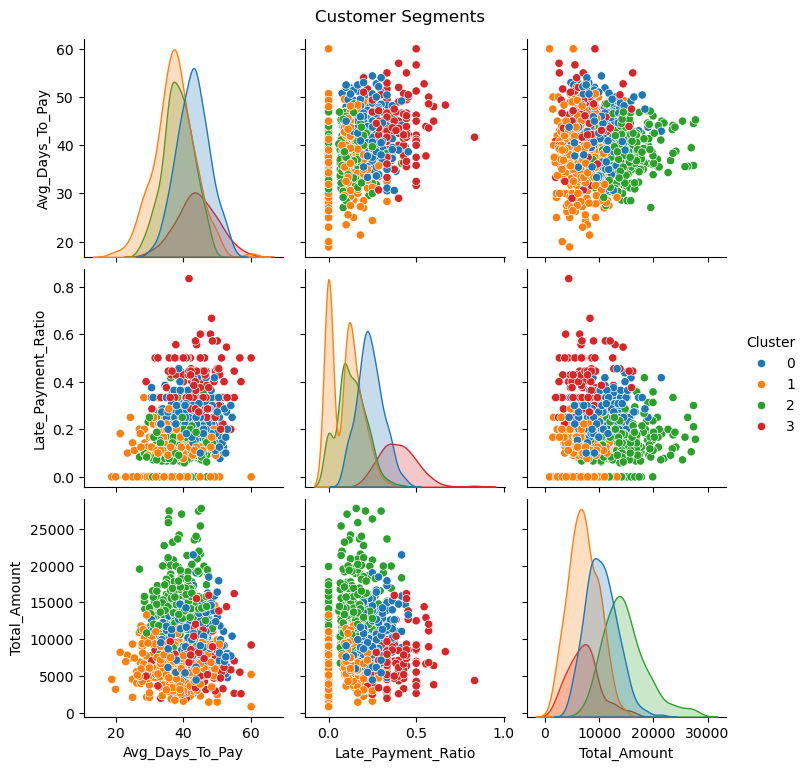

,Cluster,Avg_Days_To_Pay,Avg_Days_Overdue,Late_Payment_Ratio,Total_Amount,Invoice_Count
0,0,42.833989,3.345145,0.236932,10382.259466,10.387900
1,1,37.314643,0.778875,0.092202,7104.920173,7.890490
2,2,38.453062,1.414534,0.129747,14743.747729,13.127490
3,3,44.048611,6.061452,0.396608,7209.262397,7.834711


In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Aggregate customer-level features
customer_df = df_clean.groupby("Customer_ID").agg({
    "Days_To_Pay": "mean",
    "Days_Overdue": "mean",
    "Paid_Late": "mean",
    "Invoice_Amount": ["sum", "count"]
}).reset_index()

# Rename flattened column names
customer_df.columns = [
    "Customer_ID", 
    "Avg_Days_To_Pay", 
    "Avg_Days_Overdue", 
    "Late_Payment_Ratio", 
    "Total_Amount", 
    "Invoice_Count"
]

# Prepare for clustering
features_to_cluster = [
    "Avg_Days_To_Pay", 
    "Avg_Days_Overdue", 
    "Late_Payment_Ratio", 
    "Total_Amount", 
    "Invoice_Count"
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[features_to_cluster])

# KMeans clustering
k = 4  # or use Elbow Method to choose optimal k
kmeans = KMeans(n_clusters=k, random_state=42)
customer_df["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualize clusters (pairplot)
sns.pairplot(customer_df, hue="Cluster", palette="tab10", 
             vars=["Avg_Days_To_Pay", "Late_Payment_Ratio", "Total_Amount"])
plt.suptitle("Customer Segments", y=1.02)
plt.show()

# View cluster summary (exclude Customer_ID)
summary = customer_df.groupby("Cluster")[features_to_cluster].mean().reset_index()
summary.style.background_gradient(cmap="YlGnBu")

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Features for model
features = ["Days_To_Pay", "Days_Overdue", "Invoice_Amount"]
X = df_clean[features]
y = df_clean["Paid_Late"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight="balanced", random_state=42)
model.fit(X_train_scaled, y_train)

X_scaled_full = scaler.transform(X)
df_clean["Late_Predicted"] = model.predict(X_scaled_full)
df_clean["Late_Probability"] = model.predict_proba(X_scaled_full)[:, 1]

In [9]:
# Aggregate customer-level features
customer_df = df_clean.groupby("Customer_ID").agg({
    "Days_To_Pay": "mean",
    "Days_Overdue": "mean",
    "Paid_Late": "mean",
    "Invoice_Amount": ["sum", "count"]
}).reset_index()

# Rename columns
customer_df.columns = [
    "Customer_ID", "Avg_Days_To_Pay", "Avg_Days_Overdue",
    "Late_Payment_Ratio", "Total_Amount", "Invoice_Count"
]

# Scale and cluster
cluster_features = ["Avg_Days_To_Pay", "Avg_Days_Overdue", "Late_Payment_Ratio", "Total_Amount", "Invoice_Count"]
X_cluster = StandardScaler().fit_transform(customer_df[cluster_features])

kmeans = KMeans(n_clusters=4, random_state=42)
customer_df["Cluster"] = kmeans.fit_predict(X_cluster)

In [10]:
# Merge cluster into invoice-level data
df_final = df_clean.merge(customer_df[["Customer_ID", "Cluster"]], on="Customer_ID", how="left")

In [11]:
def recommend_strategy(row):
    cluster = row["Cluster"]
    is_late_pred = row["Late_Predicted"]

    if cluster == 2 and is_late_pred == 0:
        return "loyalty"
    elif cluster == 2 and is_late_pred == 1:
        return "Flag for AR follow-up"
    elif cluster == 3 and is_late_pred == 1:
        return "High risk – Restrict credit terms"
    elif cluster == 3 and is_late_pred == 0:
        return "Risky, but improving – Monitor closely"
    elif is_late_pred == 1:
        return "Medium risk – Send reminders, reduce DSO"
    else:
        return "Standard – Keep terms as-is"

# Apply strategy
df_final["Recommended_Strategy"] = df_final.apply(recommend_strategy, axis=1)

In [12]:
# View sample
df_final[["Invoice_ID", "Customer_ID", "Cluster", "Late_Predicted", "Late_Probability", "Recommended_Strategy"]].head(10)

# Export full result
df_final.to_csv("AR_Strategy_Recommendations.csv", index=False)

In [14]:
!pip install openpyxl

In [15]:

df_final.to_excel("AR_Strategy_Recommendations.xlsx", index=False, engine='openpyxl')
print("✅ Excel file 'AR_Strategy_Recommendations.xlsx' has been created successfully!")

✅ Excel file 'AR_Strategy_Recommendations.xlsx' has been created successfully!


In [22]:
import pandas as pd

# 1. Summary by Cluster
summary_cluster = df_final.groupby("Cluster").agg({
    "Customer_ID": pd.Series.nunique,
    "Invoice_ID": "count",
    "Invoice_Amount": "sum",
    "Days_To_Pay": "mean",
    "Days_Overdue": "mean",
    "Late_Predicted": "mean",
    "Late_Probability": "mean"
}).reset_index()

summary_cluster.columns = [
    "Cluster", "Unique_Customers", "Invoice_Count", "Total_Amount",
    "Avg_Days_To_Pay", "Avg_Days_Overdue", "Predicted_Late_Rate", "Avg_Late_Probability"
]

# 2. Summary by Strategy
summary_strategy = df_final.groupby("Recommended_Strategy").agg({
    "Customer_ID": pd.Series.nunique,
    "Invoice_ID": "count",
    "Invoice_Amount": "sum",
    "Late_Probability": "mean",
    "Late_Predicted": "mean"
}).reset_index()

summary_strategy.columns = [
    "Recommended_Strategy", "Unique_Customers", "Invoice_Count", 
    "Total_Amount", "Avg_Late_Probability", "Predicted_Late_Rate"
]

# 3. Export everything to Excel
with pd.ExcelWriter("AR_Strategy_Recommendations.xlsx", engine="openpyxl") as writer:
    # Sheet 1: Summary by Cluster
    summary_cluster.to_excel(writer, sheet_name="Summary_By_Cluster", index=False)
    
    # Sheet 2: Summary by Strategy
    summary_strategy.to_excel(writer, sheet_name="Summary_By_Strategy", index=False)
    
    # Sheets per cluster
    for cluster in sorted(df_final["Cluster"].unique()):
        cluster_df = df_final[df_final["Cluster"] == cluster]
        cluster_df.to_excel(writer, sheet_name=f"Cluster_{cluster}", index=False)

print("✅ Excel file 'AR_Strategy_Recommendations.xlsx' with strategy & cluster summaries created.")


✅ Excel file 'AR_Strategy_Recommendations.xlsx' with strategy & cluster summaries created.
